# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [133]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [134]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [135]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [136]:
centroids = torch.rand(n_clusters, 2)*70-35

In [137]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [138]:
# random columns of data
# m is mean
# standard variation is 5
# sample is number of samples

# covariance metric = diag, more in lesson 9B
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [139]:
enumerate??
en = enumerate([n*n for n in range(10)])
for index, value in en:
  print(index, value)

0 0
1 1
2 4
3 9
4 16
5 25
6 36
7 49
8 64
9 81


In [140]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [141]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

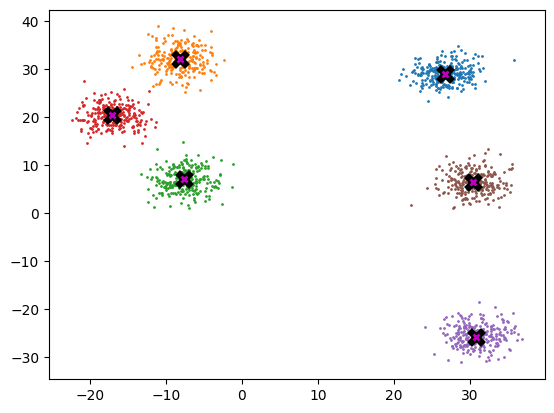

In [142]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

#<font color = red> Note: the Gaussian Kernel is same as the normal distribution !

In [143]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

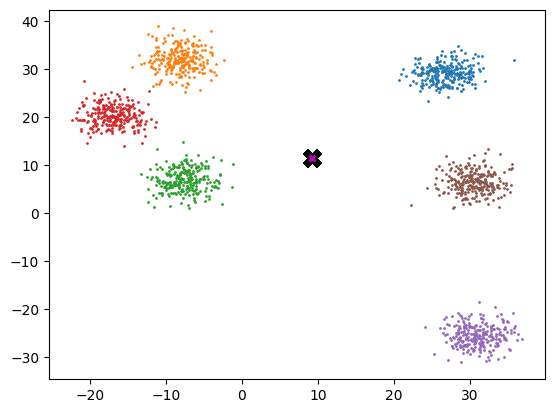

In [144]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [145]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [146]:
def plot_func(f):
    x = torch.linspace(0,10,100) # 100 data points linear spaced between 0 and 10
    plt.plot(x, f(x))

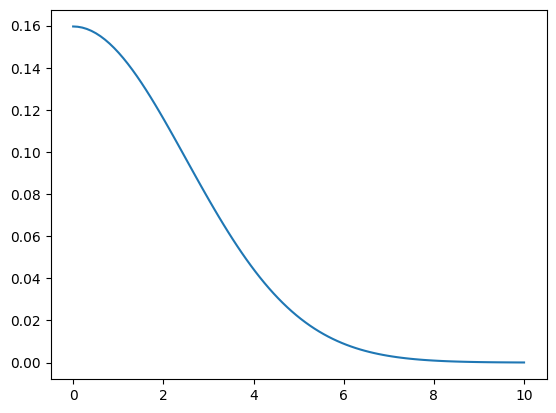

In [147]:
plot_func(partial(gaussian, bw=2.5))

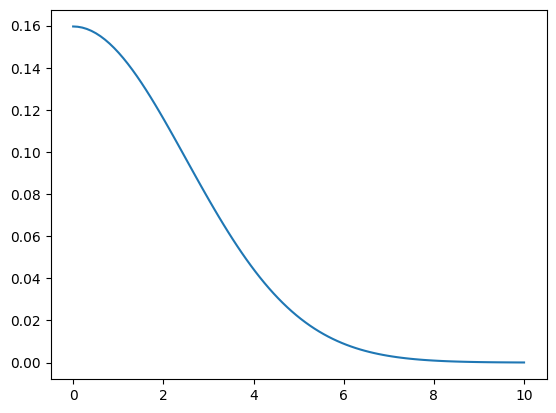

In [148]:
# partial function is same as
plot_func(lambda x: gaussian(x, bw=2.5))

In [149]:
partial

functools.partial

In [150]:
# carrying or partially applied function
partial??

In our implementation, we choose the bandwidth to be 2.5.

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [151]:
f = partial(gaussian, bw=2.5) # partial creates a new function !  2.5 is about 2 clusters
f(tensor(4.))

tensor(0.044)

In [152]:
# simpliefied gaussian function
def tri(d, i): return (-d+i).clamp_min(0)/i

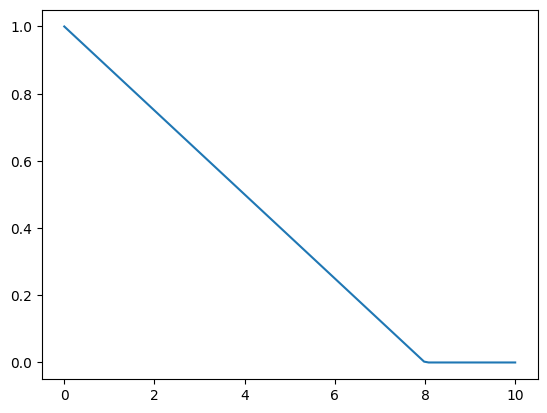

In [153]:
plot_func(partial(tri, i=8))

In [154]:
X = data.clone() # clone orignal matrix so not to overwrite
x = data[0] # first data point

In [155]:
x

tensor([26.204, 26.349])

In [156]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [157]:
x-X # find distance from one point to every other point
# Note: first distance is zero because it's the point itself

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        ...,
        [-4.568, 17.025],
        [-3.151, 22.389],
        [-4.964, 21.040]])

In [158]:
(x[None]-X)[:8] # with unit axis   8 is just an example for printing

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

`X` is the tensor that contains all the data points, with shape `(n_clusters * n_samples, 2)` in this case.
`x` is a specific data point, with shape (2,), and `x[None]` adds an extra dimension, giving it shape (1, 2).
<font color=red> `(x[None]-X)` computes the difference between x and every other point in X, effectively determining the "shift" for each data point relative to x. This is a crucial step in the Mean Shift algorithm where each data point is updated based on its neighboring points.

In [159]:
(x-X)[:8]  # 2 matches 2, first axis does not exist so broadcast/create unit axis automatically

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [160]:
# HW : rewrite using torch.einsum  (will still have x-X and have sqrt)
# euclidan distance
dist = ((x-X)**2).sum(1).sqrt() # sum x and y axis
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [161]:
weight = gaussian(dist, 2.5)
weight
# 0.160 is largest weight in plot above
# far away points have zero weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [162]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [163]:
weight[:,None].shape
# Broadcasting rules
# from right to left 1500 is compatible with 1500
# 1 is compatible with 2, because one of them is 1

torch.Size([1500, 1])

In [164]:
weight[:,None]*X # trailing unit axis

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [165]:
def one_update(X):
    for i, x in enumerate(X): # for loop will not be able to run on GPU
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum() # weighted average

In [166]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [167]:
%time X=meanshift(data)

CPU times: user 897 ms, sys: 33 µs, total: 897 ms
Wall time: 905 ms


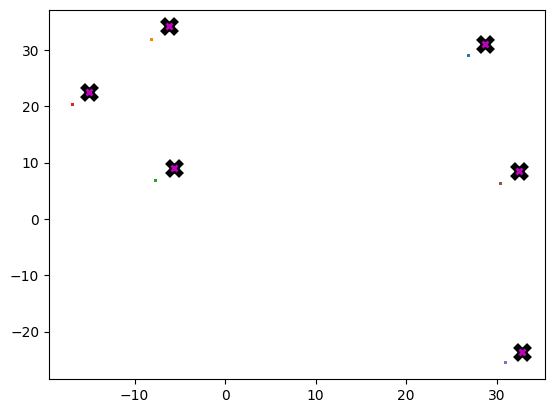

In [168]:
plot_data(centroids+2, X, n_samples) # +2 move to make dots visible

## Animation

In [169]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [170]:
def do_one(d): # d is frame number automatically
    if d: one_update(X) # for frame 0 just plot
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [171]:
# HW : create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False) # 500ms
plt.close()
HTML(ani.to_jshtml()) # to_html_mp4, see docs

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [172]:
bs=5
X = data.clone()
x = X[:bs] # first 5 points
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

#The distance should be a matrix for GPU

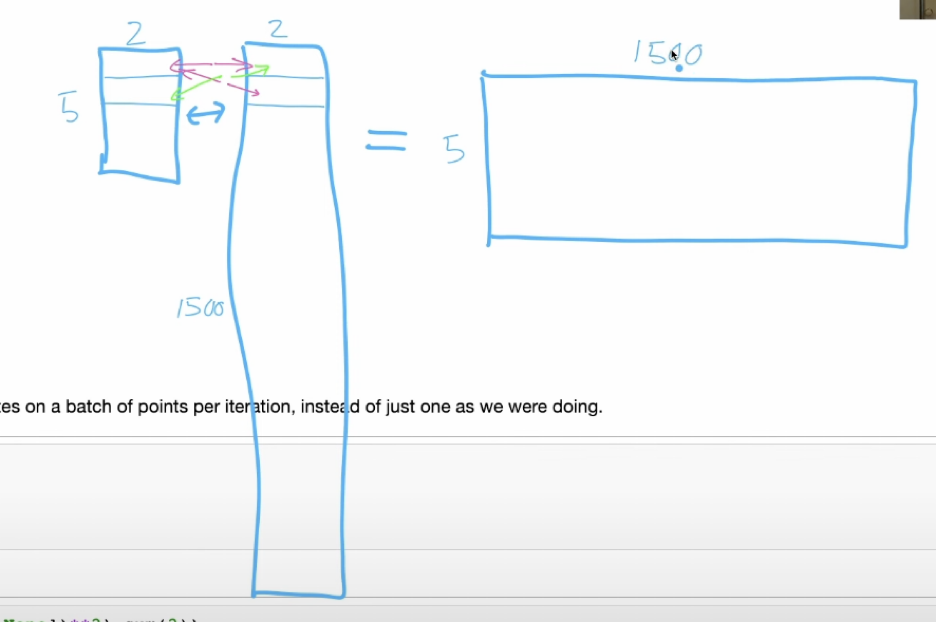

In [173]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()
# same as torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [174]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [175]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [176]:
#X-x  # shapes not compatible

In [177]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape
# Broadcasting rules
# from right to left 2 is compatible with 2
# 1500 is compatible with 1, because one of them is 2
# 1500 (rows) will be copied over 1 (5? rows)
# 1, 2 will be copied over 1500 rows ?
# 1 and 5 is compatible, because one of them is 1

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [178]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [179]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [182]:
weight[...,None].shape, X[None].shape
# broadcasting
# copy each weight 1 over 2 x,y
# copy each point 1, 5 times

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [183]:
num = (weight[...,None]*X[None]).sum(1)
num.shape # 5 new data points

torch.Size([5, 2])

In [184]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [185]:
torch.einsum('ij,jk->ik', weight, X) # same result
# Note: This is same as Matrix multiplication

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [186]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [187]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [190]:
num/div # weighted average

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [191]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n)) # re-use this slice multiple times
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [192]:
data = data.cuda()

In [193]:
X = meanshift(data).cpu()

In [206]:
%timeit -n 5 _=meanshift(data, 5000).cpu() # larger batch size is faster

6.31 ms ± 336 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


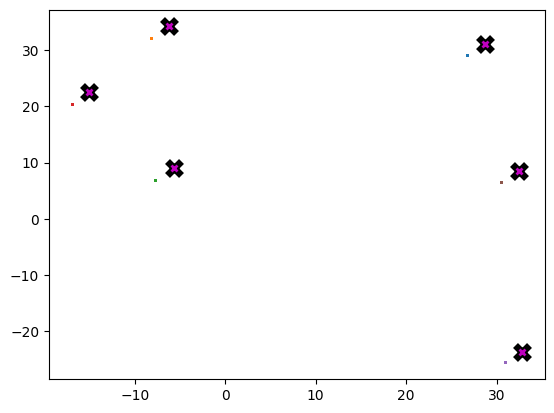

In [207]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D